In [1]:
%load_ext memory_profiler

import sys 
import os
import tensorflow as tf
import numpy as np
import sys 
import matplotlib.pyplot as plt
from tifffile import imread, imsave
from csbdeep.utils import download_and_extract_zip_file, plot_some, axes_dict, plot_history, Path, download_and_extract_zip_file
from csbdeep.data import RawData, create_patches 
from csbdeep.io import load_training_data, save_tiff_imagej_compatible
from csbdeep.models import Config, CARE
from csbdeep import data
from pathlib import Path
import os, random
import shutil
import pandas as pd
import csv

if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.') 
  print('Did you change your runtime ?') 
  print('If the runtime settings are correct then Google did not allocate GPU to your session')
  print('Expect slow performance. To access GPU try reconnecting later')

else:
  print('You have GPU access')

from tensorflow.python.client import device_lib 
device_lib.list_local_devices()
print(tf.__version__)
print("Tensorflow enabled.")

print("Depencies installed and imported.")

def Show_loss_function(history,model_path):
  '''
  Plot the loss function

  Parameters
  ----------
  history : keras object
  model_path : (str) path to the model

  Return
  ----------
  void
  '''
  # Create figure framesize
  errorfigure = plt.figure(figsize=(16,5))

  # Choose the values you wish to compare. 
  # For example, If you wish to see another values, just replace 'loss' to 'dist_loss'
  plot_history(history,['loss','val_loss']); 
  errorfigure.savefig(model_path+'/training evaluation.tif') 

  # convert the history.history dict to a pandas DataFrame:     
  hist_df = pd.DataFrame(history.history) 

  # The figure is saved into content/ as training evaluation.csv (refresh the Files if needed). 
  RESULTS = model_path+'/training evaluation.csv'
  with open(RESULTS, 'w') as f:
      for key in hist_df.keys():
          f.write("%s,%s\n"%(key,hist_df[key]))
  print("Remember you can also plot:")
  print(history.history.keys())

def Show_patches(X,Y):
  '''
  Visualize patches

  Parameters
  ----------
  X : (np.ndarray) array of patches
  Y : (np.ndarray) array of patches

  Returns
  ---------
  void

  '''
  #plot of training patches.
  plt.figure(figsize=(12,5))
  plot_some(X[:5],Y[:5])
  plt.suptitle('5 example training patches (top row: source, bottom row: target)');

  #plot of validation patches
  plt.figure(figsize=(12,5))
  plot_some(X_val[:5],Y_val[:5])
  plt.suptitle('5 example validation patches (top row: source, bottom row: target)');


def Predict_a_image(Training_source,Training_target,model_path,model_training):
  '''
  Predict a random image for a quick reference of the model

  Parameters
  ----------
  Training_source : (str) Path to the noisy images
  Training_target : (str) Path to the GT images
  model_path : (str) Path to the model
  model_trainin: (keras model) load the model to make a prediction

  Returns
  -------
  void
  '''
  # This will display a randomly chosen dataset input and output
  random_choice = random.choice(os.listdir(Training_source))
  x = imread(Training_source+"/"+random_choice)

  os.chdir(Training_target)
  y = imread(Training_target+"/"+random_choice)

  f=plt.figure(figsize=(16,8))
  plt.subplot(1,2,1)
  plt.imshow(x, interpolation='nearest')
  plt.title('Training source')
  plt.axis('off');

  plt.subplot(1,2,2)
  plt.imshow(y, interpolation='nearest')
  plt.title('Training target')
  plt.axis('off');
  
  #Create a temporary file folder for immediate assessment of training results:
  #If the folder still exists, delete it
  if os.path.exists(Training_source+"/temp"):
    shutil.rmtree(Training_source+"/temp")

  if os.path.exists(Training_target+"/temp"):
    shutil.rmtree(Training_target+"/temp")

  if os.path.exists(model_path+"/temp"):
    shutil.rmtree(model_path+"/temp")

#Create directories to move files temporarily into for assessment
  os.makedirs(Training_source+"/temp")
  os.makedirs(Training_target+"/temp")
  os.makedirs(model_path+"/temp")
#Move files into the temporary source and target directories:
  shutil.move(Training_source+"/"+random_choice, Training_source+'/temp/'+random_choice)
  shutil.move(Training_target+"/"+random_choice, Training_target+'/temp/'+random_choice)

#Here we predict one image
  validation_image = imread(Training_source+"/temp/"+random_choice)
  validation_test = model_training.predict(validation_image, axes='YX')
  os.chdir(model_path+"/temp/")
  imsave(random_choice+"_predicted.tif",validation_test)
#Source
  I = imread(Training_source+"/temp/"+random_choice)
#Target
  J = imread(Training_target+"/temp/"+random_choice)
#Prediction
  K = imread(model_path+"/temp/"+random_choice+"_predicted.tif")
#Make a plot
  f=plt.figure(figsize=(24,12))
  plt.subplot(1,3,1)
  plt.imshow(I, interpolation='nearest')
  plt.title('Source')
  plt.axis('off');

  plt.subplot(1,3,2)
  plt.imshow(J, interpolation='nearest')
  plt.title('Target')
  plt.axis('off');

  plt.subplot(1,3,3)
  plt.imshow(K, interpolation='nearest')
  plt.title('Prediction')
  plt.axis('off');

#Move the temporary files back to their original folders
  shutil.move(Training_source+'/temp/'+random_choice, Training_source+"/"+random_choice)
  shutil.move(Training_target+'/temp/'+random_choice, Training_target+"/"+random_choice)

#Delete the temporary folder
  shutil.rmtree(Training_target+'/temp')
  shutil.rmtree(Training_source+'/temp')


def train( Training_source = ".",
                Training_target = ".",
                model_name = "No_name",
                model_path = ".",
                Visual_validation_after_training = True,
                number_of_epochs =  100,
                patch_size =  64,
                number_of_patches =   10,
                Use_Default_Advanced_Parameters = True,
                number_of_steps =  300,
                batch_size =  32,
                percentage_validation =  15):
  '''
  Main function of the script. Train the model an save in model_path

  Parameters
  ----------
  Training_source : (str) Path to the noisy images
  Training_target : (str) Path to the GT images
  model_name : (str) name of the model
  model_path : (str) path of the model
  Visual_validation_after_training : (bool) Predict a random image after training
  Number_of_epochs : (int) epochs
  path_size : (int) patch sizes
  number_of_patches : (int) number of patches for each image
  User_Default_Advances_Parameters : (bool) Use default parameters for the training
  number_of_steps : (int) number of steps
  batch_size : (int) batch size
  percentage_validation : (int) percentage validation

  Return
  -------
  void
  '''
  print(Training_target)
  print(Training_source)
  OutputFile = Training_target+"/*.tif"
  InputFile = Training_source+"/*.tif"
  base = "."
  training_data = base+"/my_training_data.npz"
  if (Use_Default_Advanced_Parameters): 
    print("Default advanced parameters enabled")
    batch_size = 64
    percentage_validation = 10

  percentage = percentage_validation/100
  #here we check that no model with the same name already exist, if so delete
  if os.path.exists(model_path+'/'+model_name):
    print("Carefull, eliminating a pre-existing model")
    shutil.rmtree(model_path+'/'+model_name)

  # The shape of the images.
  print("Reading random images")
  #x = imread(InputFile)
  #y = imread(OutputFile)

  #print('Loaded Input images (number, width, length) =', x.shape)
  #print('Loaded Output images (number, width, length) =', y.shape)
  print("Parameters initiated.")


  # RawData Object

  # This object holds the image pairs (GT and low), ensuring that CARE compares corresponding images.
  # This file is saved in .npz format and later called when loading the trainig data.

  raw_data = data.RawData.from_folder(
      basepath=base,
      source_dirs=[Training_source], 
      target_dir=Training_target, 
      axes='CYX', 
      pattern='*.tif*')

  X, Y, XY_axes = data.create_patches(
      raw_data, 
      patch_filter=None, 
      patch_size=(patch_size,patch_size), 
      n_patches_per_image=number_of_patches)

  print ('Creating 2D training dataset')
  training_path = model_path+"/rawdata"
  rawdata1 = training_path+".npz"
  np.savez(training_path,X=X, Y=Y, axes=XY_axes)

  # Load Training Data
  (X,Y), (X_val,Y_val), axes = load_training_data(rawdata1, validation_split=percentage, verbose=True)
  c = axes_dict(axes)['C']
  n_channel_in, n_channel_out = X.shape[c], Y.shape[c]
  #Show_patches(X,Y)

  #Here we automatically define number_of_step in function of training data and batch size
  if (Use_Default_Advanced_Parameters): 
    number_of_steps= int(X.shape[0]/batch_size)+1

  print(number_of_steps)

  #Here we create the configuration file

  config = Config(axes, n_channel_in, n_channel_out, probabilistic=False, train_steps_per_epoch=number_of_steps, train_epochs=number_of_epochs, unet_kern_size=5, unet_n_depth=3, train_batch_size=batch_size, train_learning_rate=0.0004)

  print(config)
  vars(config)

  # Compile the CARE model for network training
  model_training= CARE(config, model_name, basedir=model_path)


  if (Visual_validation_after_training):
    Cell_executed = 1


  import time
  start = time.time()

  #@markdown ##Start Training

  # Start Training
  history = model_training.train(X,Y, validation_data=(X_val,Y_val))

  print("Training, done.")
  if (Visual_validation_after_training):
    Predict_a_image(Training_source,Training_target,model_path,model_training)

  # Displaying the time elapsed for training
  dt = time.time() - start
  min, sec = divmod(dt, 60) 
  hour, min = divmod(min, 60) 
  print("Time elapsed:",hour, "hour(s)",min,"min(s)",round(sec),"sec(s)")

  Show_loss_function(history,model_path)

Using TensorFlow backend.


You have GPU access
1.15.0
Tensorflow enabled.
Depencies installed and imported.


Y:\LuisFel\MSB131-forTrain\Process\GTv3
Y:\LuisFel\MSB131-forTrain\Process\Noisev3
Default advanced parameters enabled
Reading random images
Parameters initiated.
 1200 raw images x    1 transformations   =  1200 images
 1200 images     x   15 patches per image = 18000 patches in total
Input data:
.: target='Y:\LuisFel\MSB131-forTrain\Process\GTv3', sources=['Y:\\LuisFel\\MSB131-forTrain\\Process\\Noisev3'], axes='CYX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
128 x 128


c:\users\lab-nmsb\appdata\local\programs\python\python36\lib\site-packages\csbdeep\data\generate.py:303: RuntimeWarning: overflow encountered in long_scalars
  n_required_memory_bytes = 2 * n_patches*np.prod(patch_size) * 4
100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [07:11<00:00,  2.78it/s]


Creating 2D training dataset
number of training images:	 16200
number of validation images:	 1800
image size (2D):		 (128, 128)
axes:				 SYXC
channels in / out:		 1 / 1
254
Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=64, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=254, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=3, unet_n_first=32, unet_residual=True)














The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for 

Epoch 19/100
254/254 [==============================] - 86s 340ms/step - loss: 0.0297 - mse: 0.0243 - mae: 0.0297 - val_loss: 0.0279 - val_mse: 0.0215 - val_mae: 0.0279
Epoch 20/100
254/254 [==============================] - 86s 340ms/step - loss: 0.0294 - mse: 0.0241 - mae: 0.0294 - val_loss: 0.0278 - val_mse: 0.0214 - val_mae: 0.0278
Epoch 21/100
254/254 [==============================] - 86s 340ms/step - loss: 0.0292 - mse: 0.0233 - mae: 0.0292 - val_loss: 0.0278 - val_mse: 0.0207 - val_mae: 0.0278
Epoch 22/100
254/254 [==============================] - 87s 341ms/step - loss: 0.0294 - mse: 0.0234 - mae: 0.0294 - val_loss: 0.0274 - val_mse: 0.0206 - val_mae: 0.0274
Epoch 23/100
254/254 [==============================] - 86s 340ms/step - loss: 0.0292 - mse: 0.0223 - mae: 0.0292 - val_loss: 0.0290 - val_mse: 0.0205 - val_mae: 0.0290
Epoch 24/100
254/254 [==============================] - 87s 341ms/step - loss: 0.0290 - mse: 0.0226 - mae: 0.0290 - val_loss: 0.0276 - val_mse: 0.0196 - va

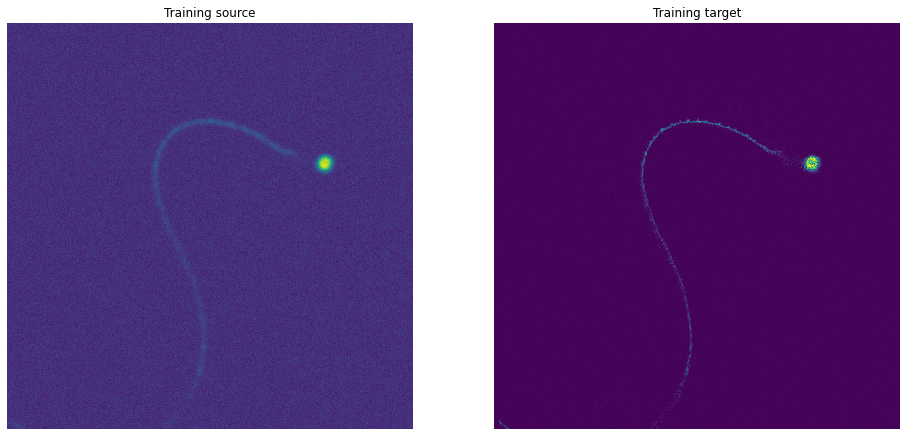

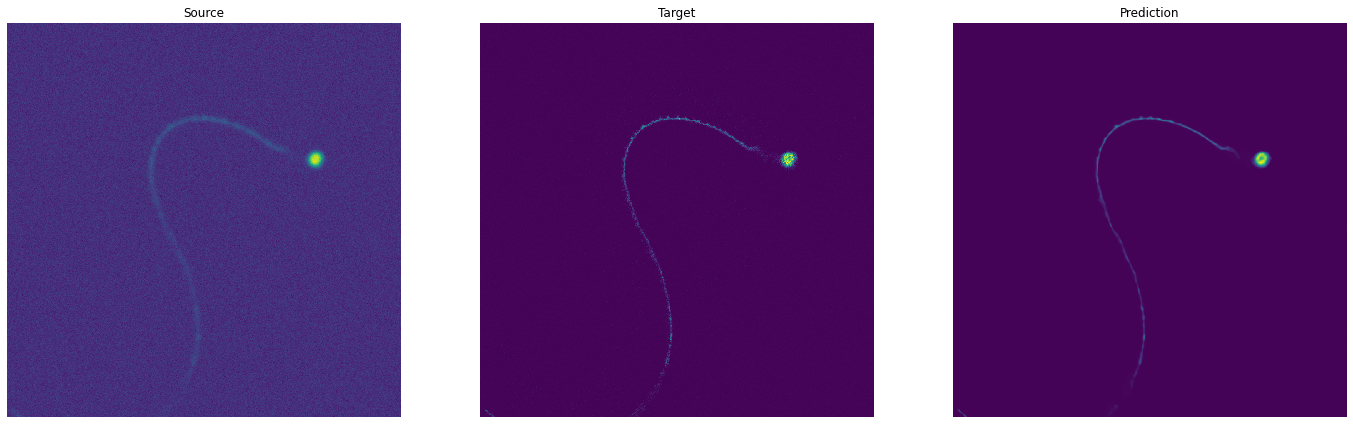

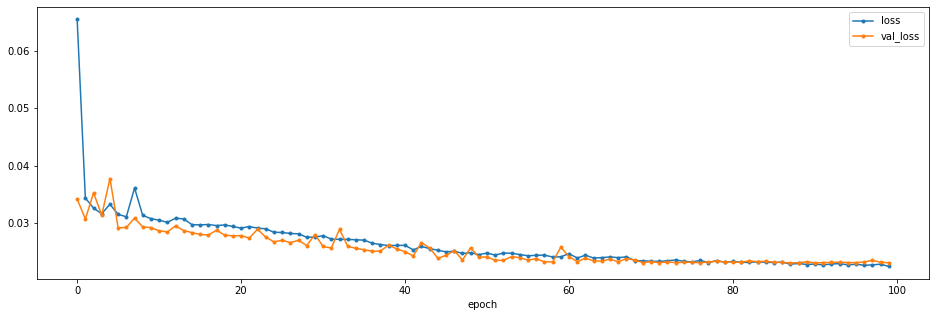

Remember you can also plot:
dict_keys(['val_loss', 'val_mse', 'val_mae', 'loss', 'mse', 'mae', 'lr'])


In [2]:
#@markdown ###Path to training images:
os.chdir('Y:\LuisFel\MSB131-forTrain\Process')
path = os.getcwd()
# low SNR images
# low = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/CARE (2D)/Training - Low SNR images" #@param {type:"string"}
Training_source = os.path.join(path,"Noisev3")#os.path.join("Images","Low") #@param {type:"string"}

# Ground truth images
# GT = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/CARE (2D)/Training - High SNR images" #@param {type:"string"}
Training_target = os.path.join(path,"GTv3")#os.path.join("Images","Max") #@param {type:"string"}

# model name and path
#@markdown ###Name of the model and path to model folder:
model_name = "261020_MSB531_Aug_Neurons" #@param {type:"string"}
model_path = os.path.join(path,"models") #@param {type:"string"}

#@markdown ####Use one image of the training set for visual assessment of the training:
Visual_validation_after_training = True #@param {type:"boolean"}
raw_data = False #@param {type:"boolean"}


# other parameters for training.
#@markdown ###Training Parameters
#@markdown Number of epochs:

number_of_epochs =  100#@param {type:"number"}

#@markdown Patch size (pixels) and number
patch_size = 128#@param {type:"number"} # in pixels

number_of_patches = 15#@param {type:"number"}


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}
#@markdown ###If not, please input:

number_of_steps =  300 #@param {type:"number"}
batch_size =  64#@param {type:"number"}
percentage_validation =  15 #@param {type:"number"}

train(Training_source, Training_target,
                model_name,
                model_path,
                Visual_validation_after_training,
                number_of_epochs,
                patch_size,
                number_of_patches,
                Use_Default_Advanced_Parameters,
                number_of_steps,
                batch_size,
                percentage_validation)